In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import jit,njit
from numba import int32, float32 ,float64   # import the types
from numba.experimental import jitclass
from numba.typed import List as NumbaList
from scipy.integrate import solve_ivp
from typing import List
exp=np.exp

@jit
def alpha_m (V):
    return -0.025*(V+40.)/( exp(-(V+40)/10) - 1.0 )
@jit
def beta_m(V):
    return exp(-(V+65)/18)
@jit
def mNa_inf(V):
    return alpha_m(V) / (alpha_m(V) + beta_m(V))
@jit
def tau_mNa(V):
    return 1 / (alpha_m(V) + beta_m(V))/5
@jit
def alpha_h(V):
    return 0.0175*exp(-(V+65)/20)
@jit
def beta_h(V):
    return 0.25/(1.0 + exp(-(V+35)/10) )
@jit
def hNa_inf(V):
    return alpha_h(V) / (alpha_h(V) + beta_h(V))
@jit
def tau_hNa (V):
    return 1 / (alpha_h(V) + beta_h(V))/5
Kdshift=10.0
@jit
def alpha_mKd(V):
    return 0.0025*(V+55.)/(1. - exp(-(V+55.)/10.))

@jit
def beta_mKd(V):
    return 0.03125*exp(-(V+65.)/80.)

@jit
def mKd_inf (V):
    return alpha_mKd(V-Kdshift) / (alpha_mKd(V-Kdshift) + beta_mKd(V-Kdshift))
@jit
def tau_mKd (V):
    return 1 / (alpha_mKd(V-Kdshift) + beta_mKd(V-Kdshift))/5 

@jit
def mA_inf (V):
    return 1/(1+exp(-(V+90)/8.5))
@jit
def tau_mA (V):
    return 0.37 + 1/(exp((V+35.82)/19.697)+exp((V+79.69)/-12.7))/5
@jit
def hA_inf (V):
    return 1/(1+exp((V+78)/6))

@jit
def tau_hA(V): # Inactivation time-constant
    if (V < -63):
        tau_hA = 1/(exp((V+46.05)/5)+exp((V+238.4)/-37.45))
    else:
        tau_hA = 19
    return tau_hA/5

@jit
def mKir_inf (V):
    return 1/(1+exp((V+97.9+10)/9.7))

# T-type Ca-current (mt=activation variable, ht=inactivation variable)
@jit
def mt_inf (V):
    return 1/(1+exp(-(V+57)/6.2)) # Activation function
@jit
def tau_mt (V):
    return 0.612 + 1/(exp(-(V+131.6)/16.7)+exp((V+16.8)/18.2)) # Activation time-constant
@jit
def ht_inf(V):
    return 1/(1+exp((V+81)/4.03))# Inactivation function
@jit
def tau_ht(V): # Inactivation time-constant
    if (V < -80):
        tau_ht = exp((V+467)/66.6)
    else:
        tau_ht = (exp(-(V+21.88)/10.2)+28)
    return tau_ht


# L-type Ca-current (mL=activation variable)
@jit
def mL_inf (V):
    return 1/(1+exp(-(V+55.)/3)) # Activation function
@jit
def tau_mL(V):
    return (72*exp(-(V+45.)**2/400)+6.)# Activation time-constant

# H-current (mH=activation variable)
@jit
def alpha_mH (V):
    return exp(-14.59-(0.086*V))
@jit
def beta_mH (V):
    return exp(-1.87+(0.0701*V))
@jit
def mH_inf (V):
    return  alpha_mH(V) /(alpha_mH(V) + beta_mH(V)) # Activation function
@jit 
def tau_mH (V):
    return 1/(alpha_mH(V) + beta_mH(V)) # Activation time-constant
@jit 
def heaviside (t):
    return (1+np.sign(t))/2
@jit 
def pulse (t,ti,tf):
    return heaviside(t-ti)-heaviside(t-tf)

sin=np.sin
pi=np.pi

@jit 
def Syn_sigm(V):
    rSyn = -45;
    kSyn = 2;
    return 1/(1+exp(-(V-rSyn)/kSyn))
@jit 
def Syn_inf(V,a,b):
    return a*Syn_sigm(V)/(a*Syn_sigm(V)+b)
 
@jit 
def max_abs(a,b):
    if abs(a)>abs(b):
        return a
    else:
        return b

In [11]:
@jitclass([( "gSyn", float64[:]),( "mask", float64[:]),( "gamma_mask", float64[:])])
class neuron:
    
    min_num:float
    Iapp:float
    I1:float # Amplitude of first step input
    I2:float # Amplitude of second step input
    ti1:float # Starting time of first step input
    tf1:float # Ending time of first step input
    ti2:float # Starting time of second step input
    tf2:float # Ending time of second step input
    taunoise:float# Cutoff frequency for low-pass filtered Gaussian noise
    Ain:float# Amplitude of sinusoïdal inut
    Win:float # Frequency of  sinusoïdal inut
    gSyn:np.ndarray
    syn_num:int
    VNa:float# Sodium reversal potential 45
    VCa:float # Calcium reversal potential
    VK:float # Potassium reversal potential -90
    VH:float# Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
    Vleak:float # Reversal potential of leak channels
    VSyn:float
    gT:float # T-type calcium current maximal conductance
    gKd:float  # Delayed-rectifier potassium current maximal conductance
    gH:float# H-current maximal conductance
    gNa:float # Sodium current maximal conductance
    gA:float # A-type potassium current maximal conductance
    gKir:float  # Inward-rectifier potassium current maximal conductance
    gL:float # L-type calcium current maximal conductance
    gKCa:float # Calcium-activated potassium current maximal conductance
    a:float
    b:float
    C:float # Membrane capacitance
    gLeak:float # Leak current maximal conductance
    num_phi:int
    num_dinamics:int
    num_Theta:int
    pos_dinamics:int
    pos_Theta:int
    pos_phi:int
    pos_p:int
    pos_u_sys:int
    gamma:float
    mask:np.ndarray #freeze variable by setting 0 in the mask
    gamma_mask:np.ndarray
    alpha:float
    
    def __init__(self,p:List[float]):
        
        self.min_num=1e-60 
        self.Iapp=0. # Amplitude of constant applied current
        self.I1=0. # Amplitude of first step input
        self.I2=0. # Amplitude of second step input
        self.ti1=0. # Starting time of first step input
        self.tf1=0. # Ending time of first step input
        self.ti2=0. # Starting time of second step input
        self.tf2=0. # Ending time of second step input
        self.taunoise=0.# Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=0. # Amplitude of sinusoïdal inut
        self.Win=0. # Frequency of  sinusoïdal inut
        self.syn_num=0
        self.VNa = 45; # Sodium reversal potential 45
        self.VCa = 120.; # Calcium reversal potential
        self.VK = -90.; # Potassium reversal potential -90
        self.VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = -55.; # Reversal potential of leak channels
        self.VSyn=-120.
        
        self.gT=p[0] # T-type calcium current maximal conductance
        self.gKd=p[1]  # Delayed-rectifier potassium current maximal conductance
        self.gH=p[2] # H-current maximal conductance
        self.gNa=p[3] # Sodium current maximal conductance
        self.gA=p[4] # A-type potassium current maximal conductance
        self.gKir=p[5]  # Inward-rectifier potassium current maximal conductance
        self.gL=p[6] # L-type calcium current maximal conductance
        self.gKCa=p[7] # Calcium-activated potassium current maximal conductance
        self.a=p[8]
        self.b=p[9]
        self.C=p[10] # Membrane capacitance
        self.gLeak=p[11] # Leak current maximal conductance
        self.num()
        
    def set_rev(self,p):
        self.VNa = p[0] # Sodium reversal potential 45
        self.VCa = p[1] ; # Calcium reversal potential
        self.VK = p[2] ; # Potassium reversal potential -90
        self.VH= p[3] ; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
        self.Vleak = p[4] ; # Reversal potential of leak channels
        self.VSyn=p[5] 
        
    def num(self):
        
        num_dinamics=12+self.syn_num
        num_Theta=9+self.syn_num
        self.num_phi=num_Theta
        num_p=num_Theta**2
        num_u_sys=12+self.syn_num
        print('num_Theta',num_Theta)
        
        self.num_dinamics=num_dinamics
        self.num_Theta=num_Theta
        self.pos_dinamics=num_dinamics
        self.pos_Theta=self.pos_dinamics+num_Theta
        self.pos_phi=self.pos_Theta+self.num_phi
        self.pos_p=self.pos_phi+num_p
        self.pos_u_sys=self.pos_p+num_u_sys
        
        
    def syn_connect(self,gSyn):
        self.gSyn=gSyn #synaptic conductance[1*syn_num]
        self.syn_num=len(gSyn)
        self.num()
        
    def set_input(self,p:List[float]):
        self.Iapp=p[0] # Amplitude of constant applied current
        self.I1=p[1] # Amplitude of first step input
        self.I2=p[2] # Amplitude of second step input
        self.ti1=p[3] # Starting time of first step input
        self.tf1=p[4] # Ending time of first step input
        self.ti2=p[5] # Starting time of second step input
        self.tf2=p[6] # Ending time of second step input
        self.taunoise=p[7] # Cutoff frequency for low-pass filtered Gaussian noise
        self.Ain=p[8] # Amplitude of sinusoïdal inut
        self.Win=p[9] # Frequency of  sinusoïdal inut
        
    def sys_equ(self,t,u,V_pre:np.ndarray):
        
        V=u[0] # Membrane potential
        mNa=u[1] # Sodium current activation
        hNa=u[2] # Sodium current inactivation
        mH=u[3] # H current activation
        mt=u[4] # T-type calcium current activation
        ht=u[5] # T-type calcium current inactivation
        mA=u[6] # A-type potassium current activation
        hA=u[7] # A-type potassium current inactivation
        mKd=u[8] # Delayed-rectifier potassium current activation
        mL=u[9] # L-type calcium current activation
        Ca=u[10] # Intracellular calcium concentration
        noise=u[11] # Input noise
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[12:12+self.syn_num] # synapse
        
        
        if len(V_pre)<self.syn_num:
            raise Exception('invaild V_pre')
        
        syn_i=0.
        if self.syn_num>0:
            syn_i=-np.dot(self.gSyn,mSyn)*(V-self.VSyn)# synapse
        
        du1=1/C*(- self.gNa*mNa**3*hNa*(V-self.VNa) - self.gH*mH*(V-self.VH) - self.gT*mt**2*ht*(V-self.VCa) 
                 - self.gA*mA**4*hA*(V-self.VK) - self.gKd*mKd**4*(V-self.VK)
                 -self.gKir*mKir_inf(V)*(V-self.VK) - self.gLeak*(V-self.Vleak)- self.gL*mL*(V-self.VCa) 
                 - self.gKCa*(Ca/(15.0+Ca))**4*(V-self.VK)
                 +syn_i
             + self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) 
             + self.I2*pulse(t,self.ti2,self.tf2) + noise + self.Ain*sin(2*pi*self.Win*t)) # Voltage equation
    
        du2=1/max_abs(tau_mNa(V),self.min_num)*(-mNa+mNa_inf(V)) # gating equation
        du3=1/max_abs(tau_hNa(V),self.min_num)*(-hNa+hNa_inf(V))
        du4=1/max_abs(tau_mH(V),self.min_num)*(-mH+mH_inf(V))
        du5=1/max_abs(tau_mt(V),self.min_num)*(-mt+mt_inf(V))
        du6=1/max_abs(tau_ht(V),self.min_num)*(-ht+ht_inf(V))
        du7=1/max_abs(tau_mA(V),self.min_num)*(-mA+mA_inf(V))
        du8=1/max_abs(tau_hA(V),self.min_num)*(-hA+hA_inf(V))
        du9=1/max_abs(tau_mKd(V),self.min_num)*(-mKd+mKd_inf(V))
        du10=1/max_abs(tau_mL(V),self.min_num)*(-mL+mL_inf(V))
        du11=(-0.1*(gL*mL*(V-self.VCa))-0.01*Ca)/4 # Variation of intracellular calcium concentration
        du12=-noise/self.taunoise
        
        if self.syn_num>0:
            du13=self.a*Syn_sigm(V_pre)*(1-mSyn)-self.b*mSyn
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,*du13]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12]
#         for i in range(self.syn_num):
#             result.append(self.a*Syn_sigm(V_pre[i])*(1-mSyn[i])-self.b*mSyn[i])

        return result
    
    def equ(self,t,u):
        return self.sys_equ(t,u,np.array([0.]))
    
    def set_hyp(self,gamma,alpha,variable_mask):
        #Hyperparameters
        self.gamma=gamma
        self.mask=variable_mask #freeze variable by setting 0 in the mask
        self.gamma_mask=variable_mask*gamma
        self.alpha=alpha
    
    def init_cond(self,V0):
        x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), 
      mL_inf(V0), -10*self.gL*mL_inf(V0)*(V0-self.VCa),0.]
        
        for i in range(self.syn_num):
            x0.append(Syn_inf(V0,self.a,self.b))
        return x0
    
    def init_cond_OB(self,V0):
        x0_=self.init_cond(V0)
        V1=-np.random.rand(1)*100
        x0=self.init_cond(V1[0])
        Theta0= np.random.rand(self.num_Theta)*100.
        print(Theta0)
        print(V1)
        A0=(np.ones(self.num_Theta)*0.1)
        P0=np.diag(np.diag(np.outer(A0,A0))).flatten()
        X0_=[*x0,*Theta0,*A0,*P0,*x0_]
        return X0_
    
    def OB_ODE(self,t,u,V_pre:np.ndarray):

        V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mL,Ca,noise=u[0:12]
    
        #mSyn=[0.]
        if self.syn_num>0:
            mSyn = u[12:12+self.syn_num] # synapse

        u_sys=u[self.pos_p:self.pos_u_sys]
        P=u[self.pos_phi:self.pos_p].reshape(self.num_phi,self.num_phi)
        Theta=u[self.pos_dinamics:self.pos_Theta]
        #print(Theta)
        phi=u[self.pos_Theta:self.pos_phi]

        obesV=u_sys[0]
    
        PHI0= -mNa**3*hNa*(obesV-self.VNa) 
        PHI1= -mH*(obesV-self.VH)
        PHI2= -mt**2*ht*(obesV-self.VCa)
        PHI3= -mA**4*hA*(obesV-self.VK)
        PHI4= - mKd**4*(obesV-self.VK)
        PHI5= -mKir_inf(obesV)*(obesV-self.VK)
        PHI6= -(obesV-self.Vleak)
        PHI7= -mL*(obesV-self.VCa)
        PHI8= -(Ca/(15.0+Ca))**4*(obesV-self.VK)
        
        if self.syn_num>0:
            PHI9=-mSyn*(obesV-self.VSyn)
            PHI=np.array([PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7,PHI8,*PHI9])
        else:
            PHI=np.array([PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7,PHI8])
            
        
        Current_in= self.Iapp + self.I1*pulse(t,self.ti1,self.tf1) + self.I2*pulse(t,self.ti2,self.tf2)+ self.Ain*sin(2*pi*self.Win*t)


        

        #ODEs
        temp=self.gamma*(obesV-V)+self.gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
        temp2=1/C*(np.dot(PHI,Theta) + Current_in)
        du1=temp+temp2
        #####
        du2=1/max_abs(tau_mNa(obesV),self.min_num)*(-mNa+mNa_inf(obesV)) # gating equation
        du3=1/max_abs(tau_hNa(obesV),self.min_num)*(-hNa+hNa_inf(obesV))
        du4=1/max_abs(tau_mH(obesV),self.min_num)*(-mH+mH_inf(obesV))
        du5=1/max_abs(tau_mt(obesV),self.min_num)*(-mt+mt_inf(obesV))
        du6=1/max_abs(tau_ht(obesV),self.min_num)*(-ht+ht_inf(obesV))
        du7=1/max_abs(tau_mA(obesV),self.min_num)*(-mA+mA_inf(obesV))
        du8=1/max_abs(tau_hA(obesV),self.min_num)*(-hA+hA_inf(obesV))
        du9=1/max_abs(tau_mKd(obesV),self.min_num)*(-mKd+mKd_inf(obesV))
        du10=1/max_abs(tau_mL(obesV),self.min_num)*(-mL+mL_inf(obesV))
        du11=(-0.1*(gL*mL*(obesV-VCa))-0.01*Ca)/4 # Variation of intracellular calcium concentration
        du12=-noise/self.taunoise # Noise equation
        
        result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12]
        
        if self.syn_num>0:
            du13=self.a*Syn_sigm(V_pre)*(1-mSyn)-self.b*mSyn
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12,*du13]
        else:
            result= [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12]
        

        du17=self.gamma_mask*np.dot(P,phi)*(obesV-V)

        du18=self.mask*(-self.gamma*phi+PHI)
        #du14=(np.absolute(du14)>min_num)*du14

        du19=self.alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)

        du20=self.sys_equ(t,u_sys,V_pre)


        return [*result, *du17 ,*du18,*du19.flatten(),*du20]
    
    def OB_ODE_equ(self,t,u):
        out= self.OB_ODE(t,u,np.array([0.]))

        return (out)


In [12]:
VCa = 120.
## Definition of membrane capacitance and maximal conductance values.
gT=2.; # T-type calcium current maximal conductance
gKd=80.; # Delayed-rectifier potassium current maximal conductance
gH=0.1; # H-current maximal conductance
gNa=120.; # Sodium current maximal conductance
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance
gL=0.4; # L-type calcium current maximal conductance
gKCa=2.; # Calcium-activated potassium current maximal conductance
a=2.0
b=0.1
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance

## Input current defition
# Constant current
Iapp=0.

# Current pulses
I1=0. # Amplitude of first pulse
ti1=0. # Starting time of first pulse
tf1=50. # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=50. # Starting time of second pulse
tf2=150. # Ending time of first pulse

# Sinusoidal input
Ain=2.5 # Amplitude
Win=0.5 # Frequency

# Input noise
NoiseIN=0. # Amplitude
TauNoise=2.0 # Cut-off frequency

neuron1=neuron(NumbaList([gT,gKd,gH,gNa,gA,gKir,gL,gKCa,a,b,C,gLeak]))
neuron1.set_input(NumbaList([Iapp,I1,I2,ti1,tf1,ti2,tf2,TauNoise,Ain,Win]))



num_Theta 9


In [13]:
Tfinal=4000.0
tspan=[0.0,Tfinal]
sol=solve_ivp(neuron1.equ,tspan,neuron1.init_cond(-60))

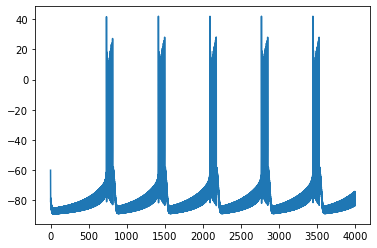

In [14]:
plt.plot(sol.t, sol.y[0])

In [15]:
#Hyperparameters
gamma=10.
alpha=0.005
variable_mask=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.])
neuron1.set_hyp(gamma,alpha,variable_mask)

In [16]:
xxx=neuron1.init_cond_OB(-70)
sol=solve_ivp(neuron1.OB_ODE_equ,tspan , xxx)

[36.22299708 18.555485   28.57973127 41.87693689 61.59104785 49.05282667
 13.63125126 15.1882148  41.01800559]
[-89.00233436]


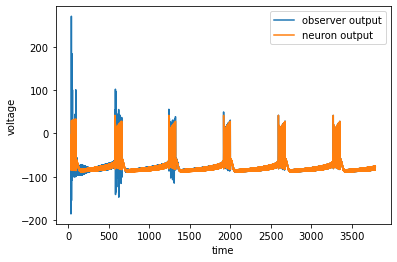

In [18]:
#plot result
fig=plt.figure()
plt.plot(sol.t[1000:30000],sol.y[0][1000:30000],label='observer output')
plt.plot(sol.t[1000:30000],sol.y[111][1000:30000],label= 'neuron output')
plt.legend()
plt.ylabel('voltage')
plt.xlabel('time')
fig.savefig('single_redundant_neuron_bursting.jpg')

In [19]:
#Test real model
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 50.; # Sodium reversal potential 45
VCa = 120.; # Calcium reversal potential
VK = -80.; # Potassium reversal potential -90
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions) -43
Vleak = -49.; # Reversal potential of leak channels
VSyn=-120.

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance
gNa=120.; # Sodium current maximal conductance
gKd=30.; # Delayed-rectifier potassium current maximal conductance
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance
gT=2.; # T-type calcium current maximal conductance
gH=0.1; # H-current maximal conductance
gL=0.4; # L-type calcium current maximal conductance
gKCa=2.; # Calcium-activated potassium current maximal conductance
gSyn=4.0
a=2.0
b=0.1
## Definition of simulation time.
Tfinal=6000.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=-4.0

# Current pulses
I1=0. # Amplitude of first pulse
ti1=0. # Starting time of first pulse
tf1=100.0 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=50.0 # Starting time of second pulse
tf2=150.0 # Ending time of first pulse

# Sinusoidal input
Ain=0.0 # Amplitude
Win=0.5 # Frequency

# Input noise
NoiseIN=0.0 # Amplitude
TauNoise=2.0 # Cut-off frequency

neuron1=neuron(NumbaList([gT,gKd,gH,gNa,gA,gKir,gL,gKCa,a,b,C,gLeak]))
neuron1.set_input(NumbaList([Iapp,2.5,I2,ti1,tf1,ti2,tf2,TauNoise,Ain,Win]))

neuron2=neuron(NumbaList([gT,gKd,gH,gNa,gA,gKir,gL,gKCa,a,b,C,gLeak]))
neuron2.set_input(NumbaList([Iapp,I1,I2,ti1,tf1,ti2,tf2,TauNoise,Ain,Win]))

neuron3=neuron(NumbaList([gT,gKd,gH,gNa,gA,gKir,gL,gKCa,a,b,C,gLeak]))
neuron3.set_input(NumbaList([Iapp,I1,I2,ti1,tf1,ti2,tf2,TauNoise,Ain,Win]))

neuron1.set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
neuron2.set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))
neuron3.set_rev(NumbaList([VNa,VCa,VK,VH,Vleak,VSyn]))


num_Theta 9
num_Theta 9
num_Theta 9


In [20]:
neuron1.syn_connect(np.array([4.]))
neuron2.syn_connect(np.array([4.]))
neuron3.syn_connect(np.array([4.]))

num_Theta 10
num_Theta 10
num_Theta 10


In [21]:
def HCO(t,u):
    neuron1_= neuron1.sys_equ(t,np.array(u[0:neuron1.pos_dinamics]),np.array([u[neuron1.pos_dinamics]]))
    neuron2_= neuron2.sys_equ(t,np.array(u[neuron1.pos_dinamics:]),np.array([u[0]]))
    return [*neuron1_,*neuron2_]

p1=neuron1.pos_dinamics
p2=neuron1.pos_dinamics+neuron2.pos_dinamics
p3=neuron1.pos_dinamics+neuron2.pos_dinamics+neuron3.pos_dinamics
def three_neurons(t,u):
    neuron1_= neuron1.sys_equ(t,np.array(u[0:p1]),np.array([u[p1]]))
    neuron2_= neuron2.sys_equ(t,np.array(u[p1:p2]),np.array([u[p2]]))
    neuron3_= neuron3.sys_equ(t,np.array(u[p2:]),np.array([u[0]]))
    return [*neuron1_,*neuron2_,*neuron3_]

p4=neuron1.pos_u_sys+neuron1.pos_p
p5=neuron1.pos_u_sys*2+neuron1.pos_p
def three_neurons_OB(t,u):
    neuron1_= neuron1.OB_ODE(t,np.array(u[0:neuron1.pos_u_sys]),np.array([u[p4]]))
    neuron2_= neuron2.OB_ODE(t,np.array(u[neuron1.pos_u_sys:neuron1.pos_u_sys*2]),np.array([u[p5]]))
    neuron3_= neuron3.OB_ODE(t,np.array(u[neuron1.pos_u_sys*2:]),np.array([u[0]]))
    return [*neuron1_,*neuron2_,*neuron3_]

In [22]:
X0=[*neuron1.init_cond(-70),*neuron2.init_cond(-63)]

In [23]:
start = time.time()
sol2=solve_ivp(HCO ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 17.77787160873413


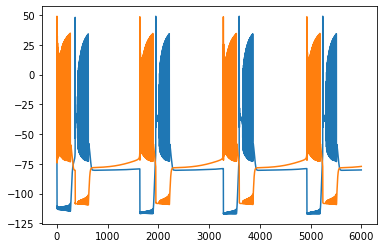

In [24]:
plt.plot(sol2.t, sol2.y[neuron1.pos_dinamics])
plt.plot(sol2.t, sol2.y[0])

In [25]:
# Initial conditions
X0= [*neuron1.init_cond(-70),*neuron2.init_cond(-63),*neuron3.init_cond(-60)]


In [26]:
start = time.time()
sol3=solve_ivp(three_neurons,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 29.088329792022705


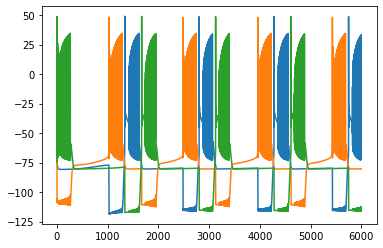

In [27]:
plt.plot(sol3.t, sol3.y[neuron1.pos_dinamics])
plt.plot(sol3.t, sol3.y[neuron1.pos_dinamics*2])
plt.plot(sol3.t, sol3.y[0])

In [28]:
#Hyperparameters
gamma=10.
alpha=0.005
variable_mask=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
neuron1.set_hyp(gamma,alpha,variable_mask)
neuron2.set_hyp(gamma,alpha,variable_mask)
neuron3.set_hyp(gamma,alpha,variable_mask)
## Definition of simulation time.
Tfinal=6000.0
tspan=[0.0,Tfinal]

In [29]:
X0_=[*neuron1.init_cond_OB(-70),*neuron2.init_cond_OB(-63),*neuron3.init_cond_OB(-60)]

[53.71668028 60.37730514 39.70009123 75.67794539 42.32508917 26.92052096
 71.01043242 42.14465712 52.65202783 72.87608466]
[-18.85057868]
[60.14614758 35.92049811 29.28406014 50.86136076 40.32642506 63.50633799
 12.16775148 43.59638202  0.72723364 85.21922585]
[-34.81990326]
[62.62994444 82.11058011 64.43286353 18.33410192 27.14446209 46.49174216
 66.33184766  1.27471754 76.83855206 53.72520234]
[-35.71809736]


In [30]:
sol4=solve_ivp(three_neurons_OB,tspan,X0_)

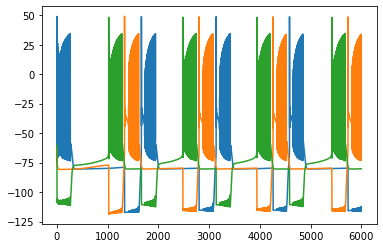

In [31]:
plt.plot(sol4.t, sol4.y[neuron1.pos_p])
plt.plot(sol4.t, sol4.y[neuron1.pos_u_sys+neuron1.pos_p])
plt.plot(sol4.t, sol4.y[neuron1.pos_u_sys*2+neuron1.pos_p])

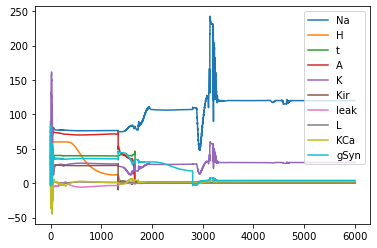

['Na', 'H', 't', 'A', 'K', 'Kir', 'leak', 'L', 'KCa', 'gSyn']
[ 1.19999516e+02  9.99980919e-02  2.00029551e+00  9.54846828e-04
  2.99997981e+01 -2.02519030e-07  1.00001713e-01  3.99977029e-01
  1.99996218e+00  4.00000340e+00]


In [32]:
#plot parameters
labels=[ 'Na','H','t','A','K','Kir','leak','L','KCa','gSyn']
plt.figure()
for i in range(10):
    plt.plot(sol4.t,sol4.y[neuron1.pos_dinamics+i],label=labels[i])
plt.legend()
plt.show()
print(labels)
print(sol4.y[neuron1.pos_dinamics:neuron1.pos_dinamics+10,-1])

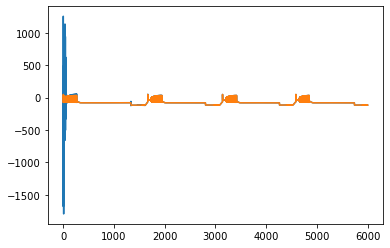

In [33]:
plt.plot(sol4.t, sol4.y[0])
plt.plot(sol4.t, sol4.y[neuron1.pos_p])

In [92]:
class network:
    
    def __init__(self,cells,connections,learn_topo=False):
        self.cells=cells
        self.connections=connections
        self.num_cell=len(cells)
        self.links=[[] for i in range(self.num_cell)]
        self.links_ob=[[] for i in range(self.num_cell)]
        
        pos=[0 for i in range(self.num_cell)]
        pos_ob=[0 for i in range(self.num_cell)]
        
        
        if (learn_topo==False):
            for i in range(self.num_cell-1):
                pos[i+1]=pos[i]+cells[i].pos_dinamics
                pos_ob[i+1]=pos_ob[i]+cells[i].pos_u_sys

            for i in range(self.num_cell):   
                strength=[]
                for j in range(self.num_cell):
                    if connections[i][j]!=0:
                        self.links[i].append(pos[j])
                        self.links_ob[i].append(pos_ob[j]+cells[i].pos_p)
                        strength.append(connections[i][j])
                cells[i].syn_connect(np.array(strength))
        else:
            cells[0].syn_connect(np.array(connections[0]))
            for i in range(self.num_cell-1):
                pos[i+1]=pos[i]+cells[i].pos_dinamics
                pos_ob[i+1]=pos_ob[i]+cells[i].pos_u_sys
                cells[i+1].syn_connect(np.array(connections[i+1]))
                
            for i in range(self.num_cell):   
                for j in range(self.num_cell):
                    self.links[i].append(pos[j])
                    self.links_ob[i].append(pos_ob[j]+cells[i].pos_p)
                    
        self.pos_ob=pos_ob
        self.pos=pos
                
    
    
    def sys_equ(self,t,u):
        equ=[]
        count=0
        for i in range(self.num_cell):
            equ=[*equ,*self.cells[i].sys_equ(t
                                        ,np.array(u[count:count+self.cells[i].pos_dinamics])
                                        ,np.array(u[self.links[i]])
                                       )]
            count+=self.cells[i].pos_dinamics
        return equ
    
    def ob_equ(self,t,u):
        equ=[]
        count=0
        for i in range(self.num_cell):
            equ=[*equ,*self.cells[i].OB_ODE(t
                                        ,np.array(u[count:count+self.cells[i].pos_u_sys])
                                        ,np.array(u[self.links_ob[i]])
                                       )]
            count+=self.cells[i].pos_u_sys
        return equ

        

In [93]:
net1=network([neuron1,neuron2],[[0.,4.],[4.,0.]],True)

num_Theta 11
num_Theta 11


In [94]:
X0=[*net1.cells[0].init_cond(-70),*net1.cells[1].init_cond(-63)]
start = time.time()
sol2=solve_ivp(net1.sys_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

Elapsed (with compilation) = 35.63692855834961


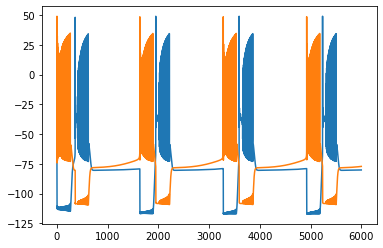

In [95]:
plt.plot(sol2.t, sol2.y[neuron1.pos_dinamics])
plt.plot(sol2.t, sol2.y[0])

In [96]:
#Hyperparameters
gamma=10.
alpha=0.005
variable_mask=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
net1.cells[0].set_hyp(gamma,alpha,variable_mask)
net1.cells[1].set_hyp(gamma,alpha,variable_mask)
## Definition of simulation time.
Tfinal=6000.0
tspan=[0.0,Tfinal]

In [97]:
X0=[*net1.cells[0].init_cond_OB(-70),*net1.cells[1].init_cond_OB(-63)]
print(len(X0))
start = time.time()
sol2=solve_ivp(net1.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[84.76928927 88.53990621 36.58349209 98.91906767 62.77875644 65.41846138
 18.88916809  6.95396091 69.82197168 39.37982765 99.45687766]
[-58.54890901]
[15.80264052  4.80084018 98.63132691 45.12927666 71.6750147  19.46480448
 50.10313818 45.4883938  56.0353849  72.05134493 88.43313966]
[-28.89300183]
342
Elapsed (with compilation) = 82.69705963134766


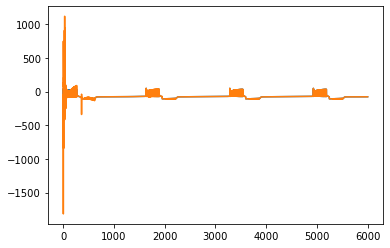

In [98]:
plt.plot(sol2.t, sol2.y[neuron1.pos_p])
plt.plot(sol2.t, sol2.y[0])

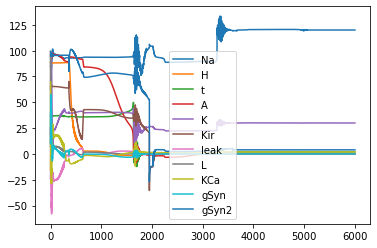

['Na', 'H', 't', 'A', 'K', 'Kir', 'leak', 'L', 'KCa', 'gSyn', 'gSyn2']
[ 1.19994040e+02  9.99839608e-02  2.00023768e+00  5.94653897e-04
  2.99987082e+01  2.10652700e-04  1.00020517e-01  3.99969585e-01
  1.99983115e+00 -2.63885889e-06  4.00006122e+00]


In [99]:
#plot parameters
labels=[ 'Na','H','t','A','K','Kir','leak','L','KCa','gSyn','gSyn2']
plt.figure()
for i in range(11):
    plt.plot(sol2.t,sol2.y[net1.cells[0].pos_dinamics+i],label=labels[i])
plt.legend()
plt.show()
print(labels)
print(sol2.y[net1.cells[0].pos_dinamics:net1.cells[1].pos_dinamics+11,-1])

In [100]:
net2=network([neuron1,neuron2,neuron3],[[0.,4.,0.],[0.,0.,4.],[4.,0.,0.]],True)

num_Theta 12
num_Theta 12
num_Theta 12


In [101]:
#Hyperparameters
gamma=10.
alpha=0.005
variable_mask=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
net2.cells[0].set_hyp(gamma,alpha,variable_mask)
net2.cells[1].set_hyp(gamma,alpha,variable_mask)
net2.cells[2].set_hyp(gamma,alpha,variable_mask)
## Definition of simulation time.
Tfinal=6000.0
tspan=[0.0,Tfinal]

In [102]:
X0=[*net2.cells[0].init_cond_OB(-70),*net2.cells[1].init_cond_OB(-63),*net2.cells[2].init_cond_OB(-60)]
print(len(X0))
start = time.time()
sol5=solve_ivp(net2.ob_equ,tspan , X0)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

[6.21721032e+01 4.73206497e+01 7.83142325e+01 5.61745545e+01
 7.39865901e-02 1.33309169e+01 9.67746489e+01 7.41909128e+01
 9.62098153e+01 5.47262543e+01 4.98158662e+00 9.16031507e+01]
[-89.64406604]
[94.64346728 31.33085972 59.49084218 45.74835124 87.83421914 71.46503388
 76.59210409  8.1039198  12.04553104 78.56503456 13.69856622 32.2128398 ]
[-23.61573289]
[55.22457491 96.03028005 26.15925319 19.80285141 47.78859354 99.33153018
 35.02558181 85.62030592 25.53130448 42.34807874 38.73940577  3.25355478]
[-6.53000022]
594
Elapsed (with compilation) = 108.85802721977234


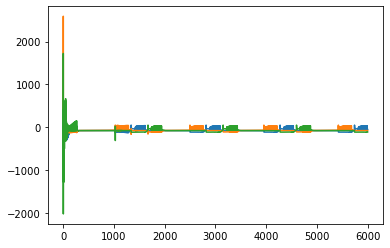

In [112]:
#plt.plot(sol5.t, sol5.y[net2.cells[0].pos_p])
#plt.plot(sol5.t, sol5.y[net2.cells[0].pos_u_sys+net2.cells[1].pos_p])
plt.plot(sol5.t, sol5.y[net2.cells[0].pos_u_sys])
plt.plot(sol5.t, sol5.y[net2.cells[0].pos_u_sys*2])
plt.plot(sol5.t, sol5.y[0])

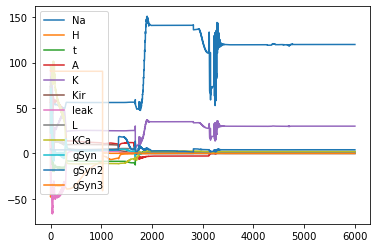

['Na', 'H', 't', 'A', 'K', 'Kir', 'leak', 'L', 'KCa', 'gSyn', 'gSyn2', 'gSyn3']
[ 1.20006748e+02  9.99994604e-02  2.00010239e+00  3.02422049e-03
  3.00021270e+01  9.10690325e-07  1.00001786e-01  4.00022760e-01
  1.99996271e+00  5.74069108e-06  4.00000896e+00 -1.83438812e-06]


In [107]:
#plot parameters
labels=[ 'Na','H','t','A','K','Kir','leak','L','KCa','gSyn','gSyn2','gSyn3']
plt.figure()
for i in range(12):
    plt.plot(sol5.t,sol5.y[net2.cells[0].pos_dinamics+i],label=labels[i])
plt.legend()
plt.show()
print(labels)
print(sol5.y[net2.cells[0].pos_dinamics:net2.cells[1].pos_dinamics+12,-1])